# Compile dataset for the neural net

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
# The %matplotlib inline command tells the IPython environment to draw the plots immediately after the current cell
%matplotlib inline

Read dataset in words

In [4]:
words = open('sample_data/names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

Build mapping of to/from integers

In [5]:
chars = sorted(list(set(''.join(words))))

# character to integer
stoi = {s:i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0

# integer to character
itos = {i:s for s,i in stoi.items()}
print(itos)



{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


Make the intial data set with the block of input and the next prediction

In [6]:
BLOCK_SIZE = 3

X = []
Y = []

for w in words:
  # Read the block.
  current_block = [0] * BLOCK_SIZE

  for ch in w + '.':
    i = stoi[ch]
    X.append(current_block)
    Y.append(i)
    # print(''.join(itos[ib] for ib in current_block), " -> " , ch)
    current_block = current_block[1:] + [i]


X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

Embedding Lookup table 
* decide the embedding size


In [7]:
# Lookup table with embedding size 2.
C = torch.randn(27,2)

# embedding is simply the lookup for each input.
embedding = C[X]


MLP: First Layer
* Decide weights and number of neurons for the first layer
* challenge will be how do you multiple embedding which is `32 * 3 * 2` matrix by weights which will be `6 * number of neurons` size.

In [ ]:
NUM_OF_NEURONS = 100

W1 = torch.randn(6, NUM_OF_NEURONS)
b1 = torch.randn(NUM_OF_NEURONS)

h = torch.tanh(embedding.view(embedding.shape[0], 6) @ W1 + b1)

In [ ]:
h

tensor([[-1.0000,  1.0000,  0.3543,  ..., -1.0000, -0.9524, -0.9405],
        [-0.9997, -0.5203,  0.9990,  ..., -1.0000,  1.0000, -0.9230],
        [ 0.9993,  0.9993, -1.0000,  ..., -0.9926, -0.8662, -0.1419],
        ...,
        [-0.9713,  0.6152, -0.7253,  ..., -0.9419,  0.6753,  0.3512],
        [-0.9487,  0.9871, -0.8801,  ...,  0.9602, -0.8803, -0.0933],
        [-0.9993, -0.1741,  0.9915,  ..., -0.9999,  0.9375, -0.9140]])

MLP: Final layer
* Outputs logits.
* Normalize the logits so that they sum to one.

In [ ]:
W2 = torch.randn(NUM_OF_NEURONS, 27)
b2 = torch.randn(27)

logits = h @ W2 + b2

# Normalize logits
counts = logits.exp()
prob = counts / counts.sum(1, keepdims = True)
prob[0].sum() 

tensor(1.0000)

Implement negative log likelihood loss
* Find the prob assigned to Y by the above NN.

In [ ]:
prob_for_Y = prob[torch.arange(32), Y]

log_likelyhood = prob_for_Y.log()

mean_log_likelyhood = log_likelyhood.mean()

# negative log likelyhood
loss = -mean_log_likelyhood
loss

IndexError: ignored

In [ ]:
F.cross_entropy(logits, Y)

tensor(15.8593)

Train the model: Lets redefine parameters with same seed.


In [13]:
g = torch.Generator().manual_seed(1232132)

# Lookup table with embedding size 2.
C = torch.randn((27, 2), generator=g)

NUM_OF_NEURONS = 100

W1 = torch.randn((6, NUM_OF_NEURONS), generator=g)
b1 = torch.randn((NUM_OF_NEURONS), generator=g)

W2 = torch.randn((NUM_OF_NEURONS, 27), generator=g)
b2 = torch.randn((27), generator=g) * 0



In [14]:
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

Train the model: Forward pass and backward pass on minibatch

In [15]:

LEARNING_RATE = 0.1
TRAINING_PASSES = 10000
MINI_BATCH_SIZE = 32

for _ in range(TRAINING_PASSES):
  # Construct minibatch
  mini_batch = torch.randint(0, X.shape[0], (MINI_BATCH_SIZE,))


  # forward pass
  embedding = C[X[mini_batch]]
  h = torch.tanh(embedding.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[mini_batch])
  print(loss.item())

  for p in parameters:
    p.grad = None

  # backward pass
  loss.backward()
  for p in parameters:
    p.data += (-LEARNING_RATE) * p.grad

print(loss.item())


Streaming output truncated to the last 5000 lines.
2.5021612644195557
2.487797498703003
2.5692012310028076
2.4950153827667236
2.5833849906921387
2.544255018234253
2.7649037837982178
2.6132171154022217
2.476442575454712
2.4240174293518066
2.944629192352295
2.7204349040985107
2.3591294288635254
3.0467405319213867
2.248975992202759
2.6354146003723145
2.1963021755218506
2.400892734527588
2.8561534881591797
2.4793813228607178
2.2682578563690186
3.205022096633911
2.7575294971466064
2.391524314880371
2.1226844787597656
2.5332274436950684
2.277344226837158
2.5249087810516357
2.434236764907837
2.396491289138794
2.4613382816314697
2.277043104171753
2.4250926971435547
2.6879003047943115
2.359222412109375
2.619145154953003
2.372842311859131
2.7494235038757324
2.3650622367858887
2.8778769969940186
2.998265027999878
2.4725327491760254
2.4261012077331543
2.711601495742798
2.55358624458313
2.557330369949341
2.5723016262054443
2.1409659385681152
2.2758426666259766
2.711759090423584
2.8310909271240234
2

Loss on the whole dataset

In [16]:
embedding = C[X]
h = torch.tanh(embedding.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.4889, grad_fn=<NllLossBackward0>)

Sample outputs from the neural net.


In [17]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    block = [0] * BLOCK_SIZE # initialize with all ...
    while True:
      emb = C[torch.tensor([block])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

NameError: ignored

Figuring out the learning rate

In [ ]:
learning_rate_exponent = torch.linspace(-3, 0, 1000)

learning_rates = 10 ** learning_rate_exponent

learning_rates

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [ ]:
MINI_BATCH_SIZE = 32

learning_rates_used = []
loss_at_learning_rate = []
for i in range(1000):
  # Construct minibatch
  mini_batch = torch.randint(0, X.shape[0], (MINI_BATCH_SIZE,))


  # forward pass
  embedding = C[X[mini_batch]]
  h = torch.tanh(embedding.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[mini_batch])

  for p in parameters:
    p.grad = None

  # backward pass
  loss.backward()
  learning_rate = learning_rates[i]
  for p in parameters:
    p.data += (-learning_rate) * p.grad

  learning_rates_used.append(learning_rate)
  loss_at_learning_rate.append(loss.item())


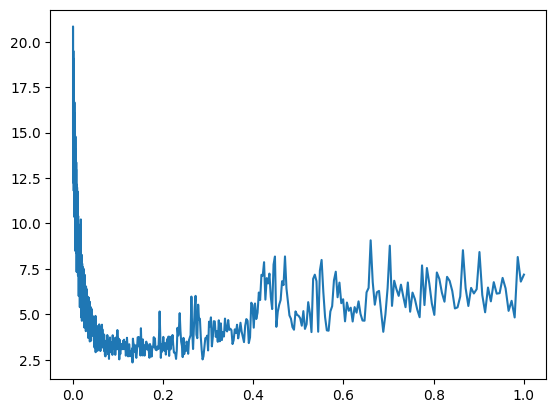

In [ ]:
plt.plot(learning_rates_used, loss_at_learning_rate)

The above plot shows that the learning rate of 0.1 is good since it gives the lowest loss.

So, lets train with that rate and plot how it behaves.

In [ ]:
MINI_BATCH_SIZE = 32

step_index = []
loss_at_index = []
for i in range(100000):
  # Construct minibatch
  mini_batch = torch.randint(0, X.shape[0], (MINI_BATCH_SIZE,))


  # forward pass
  embedding = C[X[mini_batch]]
  h = torch.tanh(embedding.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[mini_batch])

  for p in parameters:
    p.grad = None

  # backward pass
  loss.backward()
  for p in parameters:
    p.data += (-0.1) * p.grad
  step_index.append(i)
  loss_at_index.append(loss.item())


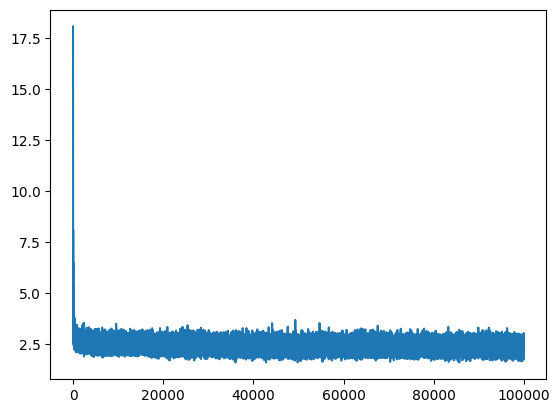

In [ ]:
plt.plot(step_index, loss_at_index)